# German Traffic Sign Recognition


The German Traffic Sign Benchmark is a multi-class, single-image classification challenge held at the International Joint Conference on Neural Networks (IJCNN) 2011. We cordially invite researchers from relevant fields to participate: The competition is designed to allow for participation without special domain knowledge. Our benchmark has the following properties:

- Single-image, multi-class classification problem
- More than 40 classes
- More than 50,000 images in total
- Large, lifelike database


<div style="text-align: center;">
  <img src="https://opentype.info/169/411237117_55d5cb699c_o.jpg" alt="Image"/>
</div>


In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'gtsrb-german-traffic-sign:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F82373%2F191501%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240827%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240827T132301Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3d1beb89c31e8a2d0ba147d0e677baa50a08cbb3f066cf41fbe080d8f25444fd088465ec08fdcec95c731a965a8b60ac61025cd33f2fc4457f53f29a4e2d6a6809fe9aa3357cba55595c5444041922093186c2189c4cdccadfbe39bf23d043d9d9f307fad51d15f859c0e21a0fe94172709c22b229f5226c9c900e3e16c369c993925a42a9269129a7d3964bec108ccf21f6ac6cdb2ce4e7967015a359da523fd4366393c237f18ee90c293c33733bcd100220c3c97a00a41c9c7552be79db97a4144deba954ed87a3fbfc7225bbd0cd7ae73f91a1cdbab617c31c7e71a242c02800ae9fced68ffba018c2098da3e76b6bceecc694164f75ab8fa797cdaa49bd'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 641568792 bytes downloaded
Downloaded and uncompressed: gtsrb-german-traffic-sign
Data source import complete.


In [2]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
# !pip install tensorflow

In [4]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D, Dropout,BatchNormalization
from sklearn.model_selection import train_test_split

In [5]:
train_csv=pd.read_csv('/kaggle/input/gtsrb-german-traffic-sign/Train.csv')
test_csv=pd.read_csv('/kaggle/input/gtsrb-german-traffic-sign/Test.csv')

In [6]:
train = '/kaggle/input/gtsrb-german-traffic-sign/train'
test = '/kaggle/input/gtsrb-german-traffic-sign/test'

In [7]:
meta='/kaggle/input/gtsrb-german-traffic-sign/Meta'

In [8]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons' }


In [9]:
path = train
labels = []
images = []

for c in classes:
  c_path = os.path.join(path,str(c))
  for img in os.listdir(c_path):
    images.append(os.path.join(c_path,img))
    labels.append(c)

In [10]:
df = pd.DataFrame()
df['images'] = images
df['labels'] = labels
df['class'] = df['labels'].map(classes)

In [11]:
df.sample(5)

,images,labels,class
7876,/kaggle/input/gtsrb-german-traffic-sign/train/...,4,Speed limit (70km/h)
23795,/kaggle/input/gtsrb-german-traffic-sign/train/...,16,Veh > 3.5 tons prohibited
27984,/kaggle/input/gtsrb-german-traffic-sign/train/...,23,Slippery road
9651,/kaggle/input/gtsrb-german-traffic-sign/train/...,5,Speed limit (80km/h)
15792,/kaggle/input/gtsrb-german-traffic-sign/train/...,10,No passing veh over 3.5 tons


In [12]:
def show_random_images_by_label(label, n=6):
    label_df = df[df['labels'] == label]

    # If there is not enough data for the label, give a warning
    if len(label_df) < n:
        print(f"There are {len(label_df)} images only")
        n = len(label_df)

    random_images = label_df.sample(n=n)

    fig, axes = plt.subplots(1, n, figsize=(20, 5))
    fig.suptitle(classes[label], fontsize=16)

    for i, (idx, row) in enumerate(random_images.iterrows()):
        img = cv2.imread(row['images'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img)
        axes[i].axis('off')

    plt.show()

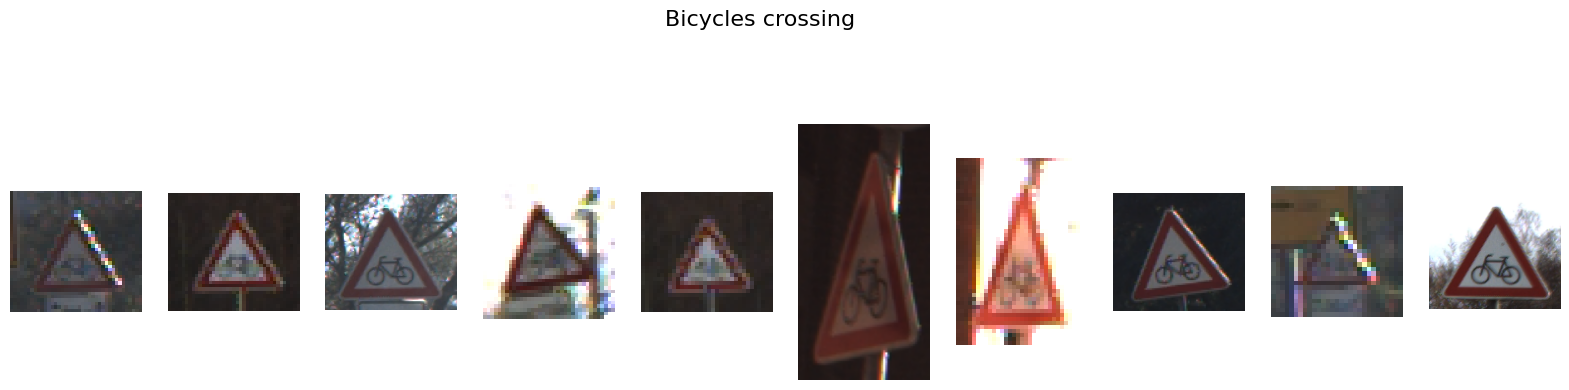

In [26]:
show_random_images_by_label(label=29, n=10)

In [14]:
x = []
for img in df['images']:
  img = cv2.imread(img)
  img = cv2.resize(img, (32,32))
  img = img / 255
  x.append(img)

In [15]:
x = np.array(x)
y = df['labels']

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [17]:

model=Sequential()
model.add(Input(shape=(32,32,3)))

model.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(43, activation='softmax'))
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

print(model.summary())



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 15, 15, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 6, 6, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 2, 2, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │          16,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 43)                  │           5,547 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 192,459 (751.79 KB)

 Trainable params: 192,011 (750.04 KB)

 Non-trainable params: 448 (1.75 KB)

None


In [18]:
history=model.fit(x_train,y_train,validation_data=(x_test,y_test), epochs=30)

Epoch 1/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.6170 - loss: 1.3351 - val_accuracy: 0.9411 - val_loss: 0.1841
Epoch 2/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9683 - loss: 0.1029 - val_accuracy: 0.9719 - val_loss: 0.0951
Epoch 3/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9799 - loss: 0.0715 - val_accuracy: 0.9813 - val_loss: 0.0733
Epoch 4/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9823 - loss: 0.0613 - val_accuracy: 0.9688 - val_loss: 0.1138
Epoch 5/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9863 - loss: 0.0438 - val_accuracy: 0.9865 - val_loss: 0.0444
Epoch 6/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9886 - loss: 0.0410 - val_accuracy: 0.9782 - val_loss: 0.0749
Epoch 7/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9910 - loss: 0.0362 - val_accuracy: 0.9878 - val_loss: 0.0457
Epoch 8/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9863 - loss: 0.0539 - val_accuracy:

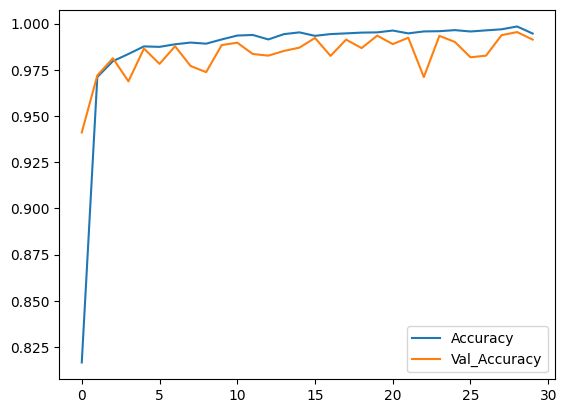

In [23]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.legend();

In [32]:
pred = model.predict(x_test)

246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


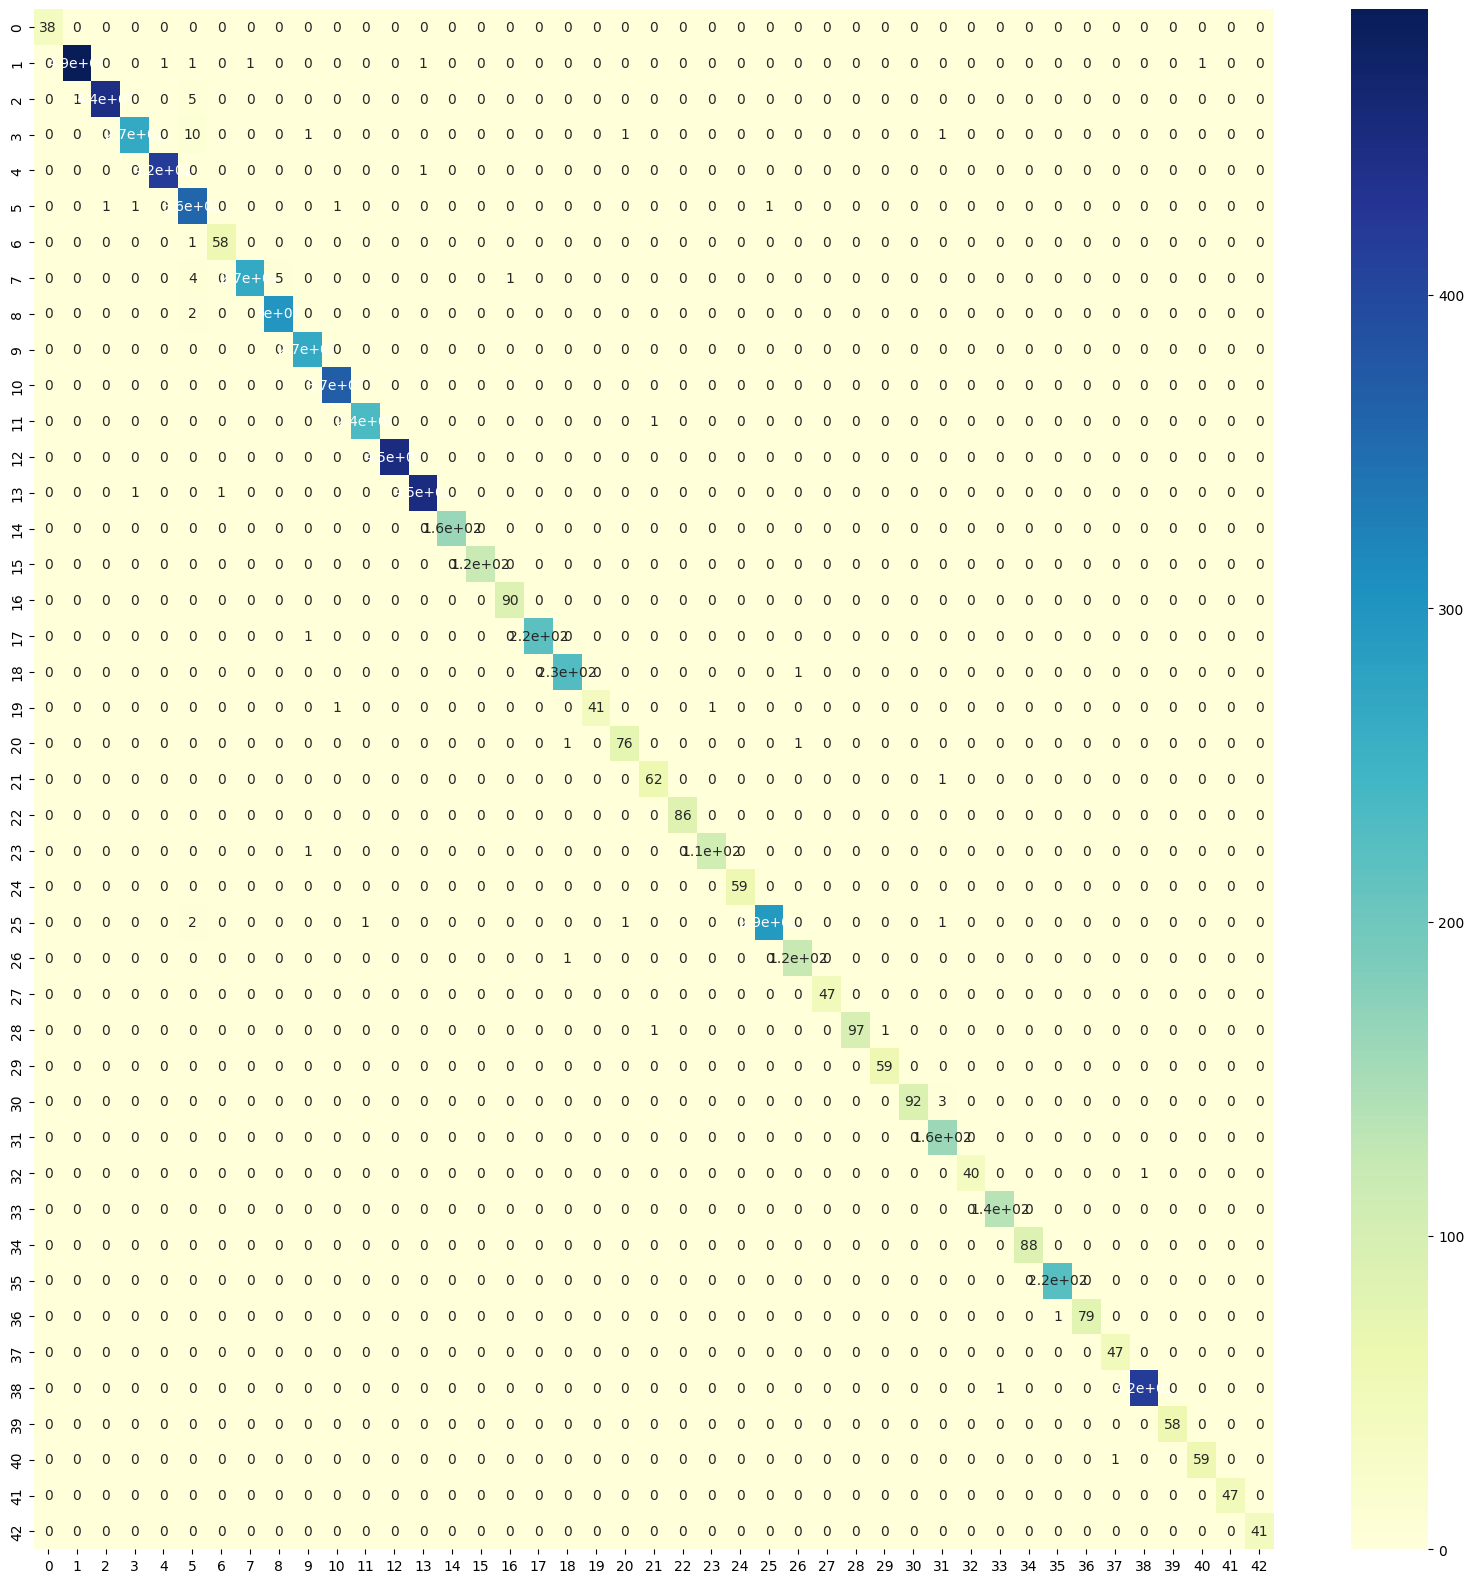

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = np.argmax(pred, axis=1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, cmap="YlGnBu", edgecolor='black');

In [37]:
model.save('gtsrb_model.h5')